# IBM SETI Tutorial 

Full documentation can be found here: https://github.com/ibm-cds-labs/seti_at_ibm/blob/master/setigopublic.md



In [1]:
import requests

## Search For Data

GET `/v1/coordinates/aca` 

#### Interesting Target

Kepler 1229b, found here http://phl.upr.edu/projects/habitable-exoplanets-catalog, is a very intersting target. This candidate has an Earth similarity index (ESI) of 0.73 (Earth = 1.0, Mars = 0.64, Jupiter = 0.12) 
and is 770 light-years away. It is the 5th highest-ranked planet by ESI. According to the catalog, it's RA/DEC coordinates are 19.832 and 46.997, respectively. 

Search the `/v1/coordinates/aca` endpoint of the public `https://setigopublic.mybluemix.net` data server to see if we have data for that location. 

Using the URL parameters, `ramin`, `ramax`, `decmin` and `decmax` for that endpoint, we define a box in the sky around that target and make our query. This ensures we find any data in the direction of the object -- allowing for a small range about its exact location.


In [90]:
#RA=19.832
#DEC=46.997
#box = 290.978

In [104]:
params = {
#'ramin':RA-box, 'ramax':RA+box, 'decmin':DEC-box, 'decmax':DEC+box, 'limit':2000
    'ramin':0, 'ramax':10, 'decmin':-90, 'decmax':90, 'limit':2000
}
r = requests.get('https://setigopublic.mybluemix.net/v1/coordinates/aca',
  params = params)

r.raise_for_status()

import json
#print json.dumps(r.json(), indent=1)
print r.json()['total_num_rows']

1919


In [105]:
params = {
#'ramin':RA-box, 'ramax':RA+box, 'decmin':DEC-box, 'decmax':DEC+box, 'limit':2000
    'ramin':10, 'ramax':24, 'decmin':-90, 'decmax':90, 'limit':2000
}
r = requests.get('https://setigopublic.mybluemix.net/v1/coordinates/aca',
  params = params)

r.raise_for_status()

import json
#print json.dumps(r.json(), indent=1)
print r.json()['total_num_rows']

1850


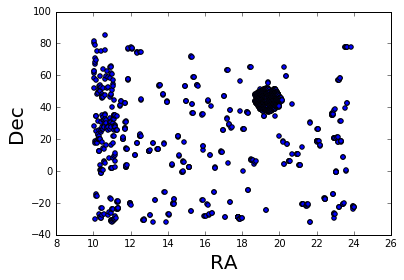

1850


In [106]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

cnt = r.json()['total_num_rows']
x = np.linspace(0, 10, cnt, dtype=float)
y = np.linspace(0, 10, cnt, dtype=float)
for i in range(cnt):
    x[i] = r.json()['rows'][i]['ra2000hr']
    y[i] = r.json()['rows'][i]['dec2000deg']

plt.scatter(x, y)
#plt.axis([18, 21, 35, 55]) #For Kepler Field (2017_05_05)
plt.xlabel(r'RA', fontsize=20)
plt.ylabel(r'Dec', fontsize=20)
plt.show()
print cnt

### SignalDB Data

GET `/v1/aca/meta/{ra}/{dec}`

We now know that data exists for this target. There are 392 "rows". This means there were 392 candidate signals found in the raw data and entered as a row in the SignalDB. But this doesn't necessarily mean there are 392 data files since the SignalDB may contain multiple rows from the same raw data source. We can obtain the SignalDB data and raw data locations for each of these rows with the `/v1/aca/meta/{ra}/{dec}` endpoint. 

In [12]:
ra = r.json()['rows'][0]['ra2000hr']
dec = r.json()['rows'][0]['dec2000deg']

r = requests.get('https://setigopublic.mybluemix.net/v1/aca/meta/{}/{}'.format(ra,dec))

r.raise_for_status()

#print json.dumps(r.json(), indent=1)
print r.json()['rows'][0]['ra2000hr']
print r.json()['total_num_rows']

19.745
40


##### r.json()

This is the SignalDB data along with the path to the raw data file (container, objectname)
By default only returns 200 rows, but can use `skip` keyword in request params to page through results.
You can also increase the number of rows returned by setting `limit=2000` (2000 is the maximum) and paginate through with `skip`.

    {
     "returned_num_rows": 200, 
     "skipped_num_rows": 0, 
     "rows": [
      {
       "inttimes": 94, 
       "pperiods": 27.36000061, 
       "pol": "mixed", 
       "tgtid": 150096, 
       "sigreason": "PsPwrT", 
       "freqmhz": 6113.461883333, 
       "dec2000deg": 46.997, 
       "container": "setiCompAmp", 
       "objectname": "2014-05-20/act14944/2014-05-20_13-00-01_UTC.act14944.dx2016.id-0.L.archive-compamp", 
       "ra2000hr": 19.832, 
       "npul": 3, 
       "acttype": null, 
       "power": 50.652, 
       "widhz": 2.778, 
       "catalog": "keplerHZ", 
       "snr": 32.397, 
       "uniqueid": "kepler8ghz_14944_2016_0_2208930", 
       "beamno": 2, 
       "sigclass": "Cand", 
       "sigtyp": "Pul", 
       "tscpeldeg": 78.558, 
       "drifthzs": -1.055, 
       "candreason": "Confrm", 
       "time": "2014-05-20T12:59:55Z", 
       "tscpazdeg": 307.339
      }, 

      ...

      "total_num_rows": 392
    }

#### SignalDB Analysis

There are many things to explore with the SignalDB data. You don't need to access the raw data (in the next step) in order to start visualizing and analyzing SETI data. 

There is no limit to how much SignalDB data you can consume! So, please feel free to pull down as much as you can. It would be interesting to see a density plot of Candidate signals and "candreason"/"sigreason" versus position in the sky, the distribution of carrier wave signal frequencies (freqmhz), drift rates, and signal types for each RA/DEC position, etc. There are lots of plots to be generated from these data alone.

## Raw Signal Data

GET `/v1/data/url/{containter}/{objectname}`

The JSON returned above contains the **container** and **objectname** of the ACA file in our Object Store service. We can retrieve the data with an HTTP request.

We use the `/v1/data/url/{container}/{objectname}` endpoint to obtain a temporary URL to the data store in Object Store. This temporary URL is valid only for 24 hours. Each Bluemix user will be alloted 20,000 temporary URLs per month. If you need more, however, send us a message and we can grant you more access. 

### Access Token

For this HTTP endpoint only, you must supply a token. This requires you to have an IBM DSX account. In addition, this endpoint has a rate limit of 20,000 requests per month. (However, if you
<a href="https://github.com/ibm-cds-labs/seti_at_ibm/blob/master/contact_us.md" target="_blank">make a compelling argument</a> for your analysis, this limit can be increased without a problem.)

1. Click on the following link: <a href="https://setigopublic.mybluemix.net/token" target="_blank">https://setigopublic.mybluemix.net/token</a> (opens a new tab). 

2. Login to DSX/Bluemix. 

3. Copy the value of the token into the `params` object below. It is passed as a query parameter.

4. Use this token for all future requests to the `/v1/data/url/{container}/{objectname}` endpoint. 


In [5]:
#params = {'access_token':'123456890abcdefg'}

In [6]:
#Get Temporary URL for the first object
#cont = r.json()['rows'][0]['container']
#objname = r.json()['rows'][0]['objectname']

#base_url = 'https://setigopublic.mybluemix.net/v1/data/url'  #this HTTP API returns a temporary URL for the container/objectname
#r = requests.get('/'.join([base_url, cont, objname]), params=params)
#r.raise_for_status()

#tmp_url = r.json()['temp_url']
#print 'URL:', tmp_url

#r_data = requests.get(tmp_url)
#r_data.raise_for_status()

#rawdata = r_data.content
#print 'file size: ', len(rawdata)

In [7]:
#print r.json()['license_notification']